In [ ]:

!pip install gdown timm

import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import timm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
# Download and extract dataset
file_id = '1jsMUDlvsXWQu2BansJz73mAErVyNg_g7'
destination = '/content/shared_file.zip'
gdown.download(id=file_id, output=destination, quiet=False)

# Check if the file is indeed a ZIP file
zip_path = '/content/shared_file.zip'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("ZIP file opened successfully.")
        zip_ref.extractall('/content')
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Downloading...
From (original): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7
From (redirected): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7&confirm=t&uuid=96d97b49-ef4a-4d0d-89a0-193e74f452c6
To: /content/shared_file.zip
100%|██████████| 1.46G/1.46G [00:28<00:00, 50.8MB/s]


ZIP file opened successfully.
Extraction complete.
Using device: cuda


In [6]:
# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img, label_tensor

# Data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

test_val_transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.ToTensor()
])

# Load data
data_dirs = {
    'T4_Ptrain': ["l0", "l1", "l2"],
    'T4_Ptest': ["l0", "l1", "l2"]
}
data_root = "/content/T4_Pdata"

# Function to load dataset
def load_data(phase, data_dirs, data_root):
    data = []
    for label, folder in enumerate(data_dirs[phase]):
        folder_path = os.path.join(data_root, phase, folder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            data.append((image_path, label))
    return data

train_data = load_data('T4_Ptrain', data_dirs, data_root)
test_data = load_data('T4_Ptest', data_dirs, data_root)

# Split train data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=[label for _, label in train_data])

# Create datasets
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=test_val_transform)
test_dataset = CustomDataset(test_data, transform=test_val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the model
model = timm.create_model("hf_hub:timm/nfnet_l0.ra2_in1k", pretrained=True)

# Modify the final layer
num_classes = len(data_dirs['T4_Ptrain'])
model.head.fc = nn.Linear(model.head.fc.in_features, num_classes)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-6)

# Define loss function with class weights
class_counts = np.bincount([label for _, label in train_data])
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/140M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [7]:
# Train the model
num_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix({'Loss': train_loss / total, 'Accuracy': 100 * correct / total})

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    scheduler.step(val_loss)

Epoch 1/100, Train Loss: 0.7525, Train Accuracy: 61.44%, Val Loss: 0.6229, Val Accuracy: 73.25%


Epoch 2/100, Train Loss: 0.5670, Train Accuracy: 71.17%, Val Loss: 0.6372, Val Accuracy: 67.36%


Epoch 3/100, Train Loss: 0.4594, Train Accuracy: 77.87%, Val Loss: 0.6304, Val Accuracy: 67.68%


Epoch 4/100, Train Loss: 0.3673, Train Accuracy: 83.73%, Val Loss: 0.5018, Val Accuracy: 80.10%


Epoch 5/100, Train Loss: 0.3284, Train Accuracy: 85.45%, Val Loss: 0.6312, Val Accuracy: 77.87%


Epoch 6/100, Train Loss: 0.2965, Train Accuracy: 86.60%, Val Loss: 0.5420, Val Accuracy: 72.93%


Epoch 7/100, Train Loss: 0.2119, Train Accuracy: 90.71%, Val Loss: 0.4945, Val Accuracy: 81.05%


Epoch 8/100, Train Loss: 0.2068, Train Accuracy: 90.95%, Val Loss: 0.4141, Val Accuracy: 85.67%


Epoch 9/100, Train Loss: 0.1505, Train Accuracy: 93.42%, Val Loss: 0.4342, Val Accuracy: 78.66%


Epoch 10/100, Train Loss: 0.1638, Train Accuracy: 93.10%, Val Loss: 0.4844, Val Accuracy: 85.19%


Epoch 11/100, Train Loss: 0.1334, Train Accuracy: 93.98%, Val Loss: 0.5237, Val Accuracy: 84.39%


Epoch 12/100, Train Loss: 0.1045, Train Accuracy: 95.30%, Val Loss: 0.4838, Val Accuracy: 83.44%


Epoch 13/100, Train Loss: 0.1096, Train Accuracy: 95.18%, Val Loss: 0.6785, Val Accuracy: 83.60%


Epoch 14/100, Train Loss: 0.1073, Train Accuracy: 95.65%, Val Loss: 0.6103, Val Accuracy: 85.67%


Epoch 15/100, Train Loss: 0.0488, Train Accuracy: 97.85%, Val Loss: 0.5436, Val Accuracy: 83.60%


Epoch 16/100, Train Loss: 0.1153, Train Accuracy: 95.57%, Val Loss: 0.3782, Val Accuracy: 85.03%


Epoch 17/100, Train Loss: 0.0806, Train Accuracy: 96.69%, Val Loss: 0.6600, Val Accuracy: 84.08%


Epoch 18/100, Train Loss: 0.0737, Train Accuracy: 96.93%, Val Loss: 0.5159, Val Accuracy: 82.32%


Epoch 19/100, Train Loss: 0.0684, Train Accuracy: 97.29%, Val Loss: 0.6713, Val Accuracy: 83.76%


Epoch 20/100, Train Loss: 0.0647, Train Accuracy: 97.33%, Val Loss: 0.5956, Val Accuracy: 84.39%


Epoch 21/100, Train Loss: 0.0518, Train Accuracy: 97.69%, Val Loss: 0.6574, Val Accuracy: 85.99%


Epoch 22/100, Train Loss: 0.1017, Train Accuracy: 96.21%, Val Loss: 0.5381, Val Accuracy: 86.78%


Epoch 23/100, Train Loss: 0.0541, Train Accuracy: 97.61%, Val Loss: 0.5867, Val Accuracy: 85.35%


Epoch 24/100, Train Loss: 0.0668, Train Accuracy: 97.29%, Val Loss: 0.6645, Val Accuracy: 85.83%


Epoch 25/100, Train Loss: 0.0636, Train Accuracy: 97.45%, Val Loss: 0.5148, Val Accuracy: 86.94%


Epoch 26/100, Train Loss: 0.0462, Train Accuracy: 98.52%, Val Loss: 0.6411, Val Accuracy: 87.74%


Epoch 27/100, Train Loss: 0.0469, Train Accuracy: 98.33%, Val Loss: 0.5402, Val Accuracy: 87.58%


Epoch 28/100, Train Loss: 0.0362, Train Accuracy: 98.72%, Val Loss: 0.4821, Val Accuracy: 87.42%


Epoch 29/100, Train Loss: 0.0180, Train Accuracy: 99.40%, Val Loss: 0.5385, Val Accuracy: 88.06%


Epoch 30/100, Train Loss: 0.0173, Train Accuracy: 99.44%, Val Loss: 0.5694, Val Accuracy: 88.06%


Epoch 31/100, Train Loss: 0.0100, Train Accuracy: 99.76%, Val Loss: 0.5964, Val Accuracy: 88.22%


Epoch 32/100, Train Loss: 0.0105, Train Accuracy: 99.64%, Val Loss: 0.6279, Val Accuracy: 87.90%


Epoch 33/100, Train Loss: 0.0070, Train Accuracy: 99.80%, Val Loss: 0.6457, Val Accuracy: 87.58%


Epoch 34/100, Train Loss: 0.0055, Train Accuracy: 99.88%, Val Loss: 0.6760, Val Accuracy: 88.06%


Epoch 35/100, Train Loss: 0.0083, Train Accuracy: 99.60%, Val Loss: 0.6901, Val Accuracy: 87.58%


Epoch 36/100, Train Loss: 0.0053, Train Accuracy: 99.96%, Val Loss: 0.7058, Val Accuracy: 87.58%


Epoch 37/100, Train Loss: 0.0054, Train Accuracy: 99.88%, Val Loss: 0.6712, Val Accuracy: 87.10%


Epoch 38/100, Train Loss: 0.0053, Train Accuracy: 99.80%, Val Loss: 0.7155, Val Accuracy: 87.10%


Epoch 39/100, Train Loss: 0.0049, Train Accuracy: 99.88%, Val Loss: 0.7147, Val Accuracy: 87.26%


Epoch 40/100, Train Loss: 0.0038, Train Accuracy: 99.92%, Val Loss: 0.7160, Val Accuracy: 87.10%


Epoch 41/100, Train Loss: 0.0047, Train Accuracy: 99.80%, Val Loss: 0.7124, Val Accuracy: 87.10%


Epoch 42/100, Train Loss: 0.0048, Train Accuracy: 99.76%, Val Loss: 0.7149, Val Accuracy: 87.10%


Epoch 43/100, Train Loss: 0.0044, Train Accuracy: 99.84%, Val Loss: 0.7177, Val Accuracy: 86.94%


Epoch 44/100, Train Loss: 0.0040, Train Accuracy: 99.92%, Val Loss: 0.7202, Val Accuracy: 86.94%


Epoch 45/100, Train Loss: 0.0045, Train Accuracy: 99.84%, Val Loss: 0.7234, Val Accuracy: 86.94%


Epoch 46/100, Train Loss: 0.0043, Train Accuracy: 99.76%, Val Loss: 0.7291, Val Accuracy: 87.10%


Epoch 47/100, Train Loss: 0.0041, Train Accuracy: 99.84%, Val Loss: 0.7351, Val Accuracy: 87.10%


Epoch 48/100, Train Loss: 0.0044, Train Accuracy: 99.80%, Val Loss: 0.7431, Val Accuracy: 87.26%


Epoch 49/100, Train Loss: 0.0042, Train Accuracy: 99.80%, Val Loss: 0.7425, Val Accuracy: 87.10%


Epoch 50/100, Train Loss: 0.0032, Train Accuracy: 99.88%, Val Loss: 0.7458, Val Accuracy: 87.10%


Epoch 51/100, Train Loss: 0.0041, Train Accuracy: 99.92%, Val Loss: 0.7440, Val Accuracy: 87.10%


Epoch 52/100, Train Loss: 0.0036, Train Accuracy: 99.84%, Val Loss: 0.7454, Val Accuracy: 87.26%


Epoch 53/100, Train Loss: 0.0033, Train Accuracy: 99.92%, Val Loss: 0.7449, Val Accuracy: 87.42%


Epoch 54/100, Train Loss: 0.0034, Train Accuracy: 99.84%, Val Loss: 0.7498, Val Accuracy: 87.42%


Epoch 55/100, Train Loss: 0.0036, Train Accuracy: 99.84%, Val Loss: 0.7500, Val Accuracy: 87.42%


Epoch 56/100, Train Loss: 0.0037, Train Accuracy: 99.84%, Val Loss: 0.7515, Val Accuracy: 87.42%


Epoch 57/100, Train Loss: 0.0040, Train Accuracy: 99.84%, Val Loss: 0.7504, Val Accuracy: 87.42%


Epoch 58/100, Train Loss: 0.0033, Train Accuracy: 99.84%, Val Loss: 0.7522, Val Accuracy: 87.10%


Epoch 59/100, Train Loss: 0.0038, Train Accuracy: 99.84%, Val Loss: 0.7548, Val Accuracy: 87.42%


Epoch 60/100, Train Loss: 0.0035, Train Accuracy: 99.92%, Val Loss: 0.7583, Val Accuracy: 87.58%


Epoch 61/100, Train Loss: 0.0032, Train Accuracy: 99.88%, Val Loss: 0.7659, Val Accuracy: 87.42%


Epoch 62/100, Train Loss: 0.0037, Train Accuracy: 99.88%, Val Loss: 0.7666, Val Accuracy: 87.10%


Epoch 63/100, Train Loss: 0.0035, Train Accuracy: 99.84%, Val Loss: 0.7656, Val Accuracy: 87.26%


Epoch 64/100, Train Loss: 0.0026, Train Accuracy: 99.92%, Val Loss: 0.7661, Val Accuracy: 87.42%


Epoch 65/100, Train Loss: 0.0034, Train Accuracy: 99.80%, Val Loss: 0.7707, Val Accuracy: 87.26%


Epoch 66/100, Train Loss: 0.0027, Train Accuracy: 99.92%, Val Loss: 0.7741, Val Accuracy: 87.42%


Epoch 67/100, Train Loss: 0.0034, Train Accuracy: 99.88%, Val Loss: 0.7734, Val Accuracy: 86.94%


Epoch 68/100, Train Loss: 0.0030, Train Accuracy: 99.96%, Val Loss: 0.7665, Val Accuracy: 86.78%


Epoch 69/100, Train Loss: 0.0032, Train Accuracy: 99.88%, Val Loss: 0.7731, Val Accuracy: 86.78%
Epoch 69/100, Train Loss: 0.0032, Train Accuracy: 99.88%, Val Loss: 0.7731, Val Accuracy: 86.78%


Epoch 70/100, Train Loss: 0.0028, Train Accuracy: 99.92%, Val Loss: 0.7781, Val Accuracy: 86.78%
Epoch 70/100, Train Loss: 0.0028, Train Accuracy: 99.92%, Val Loss: 0.7781, Val Accuracy: 86.78%


Epoch 71/100, Train Loss: 0.0024, Train Accuracy: 99.92%, Val Loss: 0.7882, Val Accuracy: 86.78%
Epoch 71/100, Train Loss: 0.0024, Train Accuracy: 99.92%, Val Loss: 0.7882, Val Accuracy: 86.78%


Epoch 72/100, Train Loss: 0.0033, Train Accuracy: 99.88%, Val Loss: 0.7747, Val Accuracy: 86.78%
Epoch 72/100, Train Loss: 0.0033, Train Accuracy: 99.88%, Val Loss: 0.7747, Val Accuracy: 86.78%


Epoch 73/100, Train Loss: 0.0032, Train Accuracy: 99.80%, Val Loss: 0.7800, Val Accuracy: 86.94%
Epoch 73/100, Train Loss: 0.0032, Train Accuracy: 99.80%, Val Loss: 0.7800, Val Accuracy: 86.94%


Epoch 74/100, Train Loss: 0.0031, Train Accuracy: 99.88%, Val Loss: 0.7838, Val Accuracy: 86.94%
Epoch 74/100, Train Loss: 0.0031, Train Accuracy: 99.88%, Val Loss: 0.7838, Val Accuracy: 86.94%


Epoch 75/100, Train Loss: 0.0026, Train Accuracy: 99.88%, Val Loss: 0.7870, Val Accuracy: 86.94%
Epoch 75/100, Train Loss: 0.0026, Train Accuracy: 99.88%, Val Loss: 0.7870, Val Accuracy: 86.94%


Epoch 76/100, Train Loss: 0.0019, Train Accuracy: 100.00%, Val Loss: 0.7994, Val Accuracy: 86.78%
Epoch 76/100, Train Loss: 0.0019, Train Accuracy: 100.00%, Val Loss: 0.7994, Val Accuracy: 86.78%


Epoch 77/100, Train Loss: 0.0022, Train Accuracy: 99.88%, Val Loss: 0.8039, Val Accuracy: 87.10%
Epoch 77/100, Train Loss: 0.0022, Train Accuracy: 99.88%, Val Loss: 0.8039, Val Accuracy: 87.10%


Epoch 78/100, Train Loss: 0.0027, Train Accuracy: 99.88%, Val Loss: 0.8079, Val Accuracy: 86.94%
Epoch 78/100, Train Loss: 0.0027, Train Accuracy: 99.88%, Val Loss: 0.8079, Val Accuracy: 86.94%


Epoch 79/100, Train Loss: 0.0029, Train Accuracy: 99.84%, Val Loss: 0.8073, Val Accuracy: 87.10%
Epoch 79/100, Train Loss: 0.0029, Train Accuracy: 99.84%, Val Loss: 0.8073, Val Accuracy: 87.10%


Epoch 80/100, Train Loss: 0.0029, Train Accuracy: 99.88%, Val Loss: 0.7977, Val Accuracy: 87.58%
Epoch 80/100, Train Loss: 0.0029, Train Accuracy: 99.88%, Val Loss: 0.7977, Val Accuracy: 87.58%


Epoch 81/100, Train Loss: 0.0025, Train Accuracy: 99.88%, Val Loss: 0.8036, Val Accuracy: 87.74%
Epoch 81/100, Train Loss: 0.0025, Train Accuracy: 99.88%, Val Loss: 0.8036, Val Accuracy: 87.74%


Epoch 82/100, Train Loss: 0.0024, Train Accuracy: 99.96%, Val Loss: 0.8053, Val Accuracy: 87.42%
Epoch 82/100, Train Loss: 0.0024, Train Accuracy: 99.96%, Val Loss: 0.8053, Val Accuracy: 87.42%


Epoch 83/100, Train Loss: 0.0022, Train Accuracy: 99.92%, Val Loss: 0.8189, Val Accuracy: 87.58%
Epoch 83/100, Train Loss: 0.0022, Train Accuracy: 99.92%, Val Loss: 0.8189, Val Accuracy: 87.58%


Epoch 84/100, Train Loss: 0.0030, Train Accuracy: 99.96%, Val Loss: 0.8281, Val Accuracy: 86.94%
Epoch 84/100, Train Loss: 0.0030, Train Accuracy: 99.96%, Val Loss: 0.8281, Val Accuracy: 86.94%


Epoch 85/100, Train Loss: 0.0020, Train Accuracy: 99.88%, Val Loss: 0.8382, Val Accuracy: 86.94%
Epoch 85/100, Train Loss: 0.0020, Train Accuracy: 99.88%, Val Loss: 0.8382, Val Accuracy: 86.94%


Epoch 86/100, Train Loss: 0.0023, Train Accuracy: 99.96%, Val Loss: 0.8275, Val Accuracy: 86.94%
Epoch 86/100, Train Loss: 0.0023, Train Accuracy: 99.96%, Val Loss: 0.8275, Val Accuracy: 86.94%


Epoch 87/100, Train Loss: 0.0026, Train Accuracy: 99.88%, Val Loss: 0.8364, Val Accuracy: 86.62%
Epoch 87/100, Train Loss: 0.0026, Train Accuracy: 99.88%, Val Loss: 0.8364, Val Accuracy: 86.62%


Epoch 88/100, Train Loss: 0.0018, Train Accuracy: 99.96%, Val Loss: 0.8396, Val Accuracy: 86.94%
Epoch 88/100, Train Loss: 0.0018, Train Accuracy: 99.96%, Val Loss: 0.8396, Val Accuracy: 86.94%


Epoch 89/100, Train Loss: 0.0019, Train Accuracy: 99.92%, Val Loss: 0.8470, Val Accuracy: 87.10%
Epoch 89/100, Train Loss: 0.0019, Train Accuracy: 99.92%, Val Loss: 0.8470, Val Accuracy: 87.10%


Epoch 90/100, Train Loss: 0.0018, Train Accuracy: 99.92%, Val Loss: 0.8505, Val Accuracy: 86.94%
Epoch 90/100, Train Loss: 0.0018, Train Accuracy: 99.92%, Val Loss: 0.8505, Val Accuracy: 86.94%


Epoch 91/100, Train Loss: 0.0024, Train Accuracy: 99.92%, Val Loss: 0.8705, Val Accuracy: 86.94%
Epoch 91/100, Train Loss: 0.0024, Train Accuracy: 99.92%, Val Loss: 0.8705, Val Accuracy: 86.94%


Epoch 92/100, Train Loss: 0.0021, Train Accuracy: 99.92%, Val Loss: 0.8705, Val Accuracy: 86.78%
Epoch 92/100, Train Loss: 0.0021, Train Accuracy: 99.92%, Val Loss: 0.8705, Val Accuracy: 86.78%


Epoch 93/100, Train Loss: 0.0018, Train Accuracy: 99.88%, Val Loss: 0.8700, Val Accuracy: 86.62%
Epoch 93/100, Train Loss: 0.0018, Train Accuracy: 99.88%, Val Loss: 0.8700, Val Accuracy: 86.62%


Epoch 94/100, Train Loss: 0.0027, Train Accuracy: 99.92%, Val Loss: 0.8720, Val Accuracy: 86.78%
Epoch 94/100, Train Loss: 0.0027, Train Accuracy: 99.92%, Val Loss: 0.8720, Val Accuracy: 86.78%


Epoch 95/100, Train Loss: 0.0022, Train Accuracy: 99.88%, Val Loss: 0.8683, Val Accuracy: 86.94%
Epoch 95/100, Train Loss: 0.0022, Train Accuracy: 99.88%, Val Loss: 0.8683, Val Accuracy: 86.94%


Epoch 96/100, Train Loss: 0.0015, Train Accuracy: 99.96%, Val Loss: 0.8824, Val Accuracy: 86.94%
Epoch 96/100, Train Loss: 0.0015, Train Accuracy: 99.96%, Val Loss: 0.8824, Val Accuracy: 86.94%


Epoch 97/100, Train Loss: 0.0020, Train Accuracy: 99.92%, Val Loss: 0.9027, Val Accuracy: 86.94%
Epoch 97/100, Train Loss: 0.0020, Train Accuracy: 99.92%, Val Loss: 0.9027, Val Accuracy: 86.94%


Epoch 98/100, Train Loss: 0.0018, Train Accuracy: 99.88%, Val Loss: 0.8996, Val Accuracy: 87.10%
Epoch 98/100, Train Loss: 0.0018, Train Accuracy: 99.88%, Val Loss: 0.8996, Val Accuracy: 87.10%


Epoch 99/100, Train Loss: 0.0016, Train Accuracy: 99.92%, Val Loss: 0.8970, Val Accuracy: 87.10%
Epoch 99/100, Train Loss: 0.0016, Train Accuracy: 99.92%, Val Loss: 0.8970, Val Accuracy: 87.10%


Epoch 100/100, Train Loss: 0.0012, Train Accuracy: 99.96%, Val Loss: 0.8931, Val Accuracy: 87.10%
Epoch 100/100, Train Loss: 0.0012, Train Accuracy: 99.96%, Val Loss: 0.8931, Val Accuracy: 87.10%


In [12]:
# Save the trained model
torch.save(model.state_dict(), '/content/nfnet_l0_model.pth')

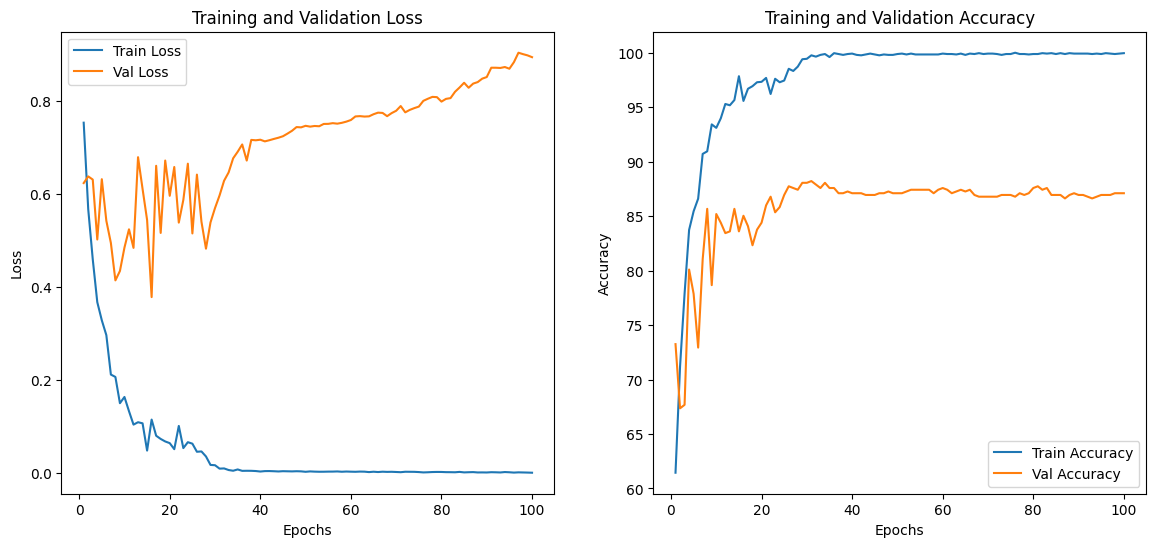

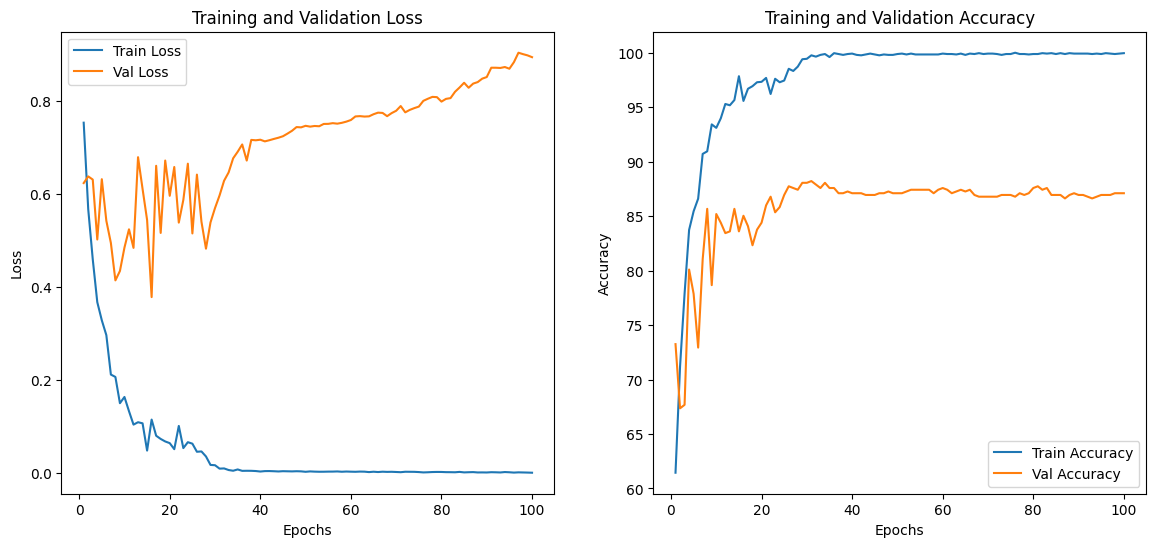

In [13]:

# Plotting training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [14]:

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)

# Generate classification report
true_labels = torch.tensor(true_labels).cpu().numpy()
predictions = torch.tensor(predictions).cpu().numpy()
report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)])
print(report)


Test Accuracy: 89.31%
              precision    recall  f1-score   support

     Class 0       0.79      0.86      0.82       118
     Class 1       0.93      0.95      0.94       187
     Class 2       0.92      0.87      0.89       322

    accuracy                           0.89       627
   macro avg       0.88      0.89      0.88       627
weighted avg       0.90      0.89      0.89       627

Test Accuracy: 89.31%
              precision    recall  f1-score   support

     Class 0       0.79      0.86      0.82       118
     Class 1       0.93      0.95      0.94       187
     Class 2       0.92      0.87      0.89       322

    accuracy                           0.89       627
   macro avg       0.88      0.89      0.88       627
weighted avg       0.90      0.89      0.89       627



In [16]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import numpy as np

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)]))

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Calculate per-class metrics
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * precision * recall / (precision + recall)

# Calculate macro-averaged metrics
macro_recall = np.mean(recall)
macro_precision = np.mean(precision)
macro_f1_score = np.mean(f1_score)
accuracy = np.sum(TP) / np.sum(cm)
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
custom_balanced_accuracy = np.mean((recall + specificity) / 2)

# Print class-wise metrics
print("\nClass-wise Metrics:")
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  Specificity: {specificity[i]:.3f}")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

# Print macro-averaged metrics
print("\nMacro-averaged Metrics:")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro F1-score: {macro_f1_score:.3f}")
print(f"Accuracy (ACC): {accuracy:.3f}")
print(f"Balanced Accuracy (BAC): {balanced_accuracy:.3f}")
print(f"Custom Balanced Accuracy (BCC): {custom_balanced_accuracy:.3f}")


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.79      0.86      0.82       118
     Class 1       0.93      0.95      0.94       187
     Class 2       0.92      0.87      0.89       322

    accuracy                           0.89       627
   macro avg       0.88      0.89      0.88       627
weighted avg       0.90      0.89      0.89       627

Confusion Matrix:
[[101   0  17]
 [  0 178   9]
 [ 27  14 281]]

Class-wise Metrics:
Class 0:
  TP: 101
  TN: 482
  FP: 27
  FN: 17
  Recall: 0.856
  Specificity: 0.947
  Precision: 0.789
  F1-score: 0.821
Class 1:
  TP: 178
  TN: 426
  FP: 14
  FN: 9
  Recall: 0.952
  Specificity: 0.968
  Precision: 0.927
  F1-score: 0.939
Class 2:
  TP: 281
  TN: 279
  FP: 26
  FN: 41
  Recall: 0.873
  Specificity: 0.915
  Precision: 0.915
  F1-score: 0.893

Macro-averaged Metrics:
Macro Recall: 0.893
Macro Precision: 0.877
Macro F1-score: 0.885
Accuracy (ACC): 0.893
Balanced Accuracy (BAC): 0.893
Custom